# Community detection in the _Drosophila_ connectome

Import `lsbm` library:

In [1]:
import lsbm

Import data:

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder as labeler
lab = np.loadtxt('../data/drosophila_labels.csv', dtype=str)
lab = labeler().fit(lab).transform(lab)
## Import embeddings
X = np.loadtxt('../data/drosophila_dase.csv', delimiter=',')
d = X.shape[1]

Define initial number of clusters:

In [3]:
K = 4

Define latent basis functions (Priebe et al., 2017 & Athreya et al., 2018):
- Cluster 0: Linearity in first component & quadratics;
- Clusters 1-3: GMM.

In [4]:
first_linear = [True, False]
fW = {}
for j in range(d):
    if j == 0:
        fW[0,0] = lambda x: np.array([x])
        fW[1,0] = lambda x: np.array([1])
    else:
        fW[0,j] = lambda x: np.array([x, x**2])
        fW[1,j] = lambda x: np.array([1])

Define `lsbm` model object:

In [5]:
m = lsbm.lsbm_gibbs(X=X, K=4, W_function=fW, K_fixed=False, first_linear=first_linear)

Initialise cluster allocations using $k$-means and match to the best fitting latent curve via the marginal likelihood:

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari
np.random.seed(171)
z_init = KMeans(n_clusters=6, random_state=0).fit_predict(X) + 1
## Initial labelling based on k-means output (following Priebe et al, 2017)
z_init[np.where(z_init == 6)[0]] = 0
z_init[np.where(z_init == 3)[0]] = 0
z_init[np.where(z_init == 4)[0]] = 0
z_init[np.where(z_init == 5)[0]] = 3
## The initial values must be labelled carefully to match the corresponding curves  
z_optim, perm_optim = lsbm.marginal_likelihood_relabeler(z_init=z_init, m=m)
ari(z_optim, lab)

0.6619431743637325

Run MCMC: 

In [7]:
q = m.mcmc(samples=10000, burn=1000, chains=1, store_chains=True, q=100, thinning=1, sigma_prop=0.1)

Chain: 1 / 1 	Burnin: 1000 / 1000 	Samples: 10000 / 100001 	Burnin: 1000 / 1000 	Samples: 2704 / 100001000 / 1000 	Samples: 6949 / 10000/ 1 	Burnin: 1000 / 1000 	Samples: 9314 / 10000


Plot number of communities:

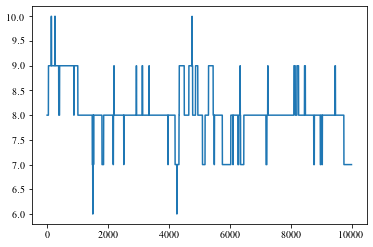

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.plot(np.apply_along_axis(func1d=lambda x: len(np.unique(x)), axis=0, arr=q[1][:,0]))
plt.show()

Estimate and plot clusters:

In [11]:
import estimate_cluster
psm = np.zeros((m.n,m.n))
for z in q[1][:,0].T:
    psm += np.equal.outer(z,z)
psm /= q[1].shape[2]
z_est = estimate_cluster.estimate_clustering(psm)

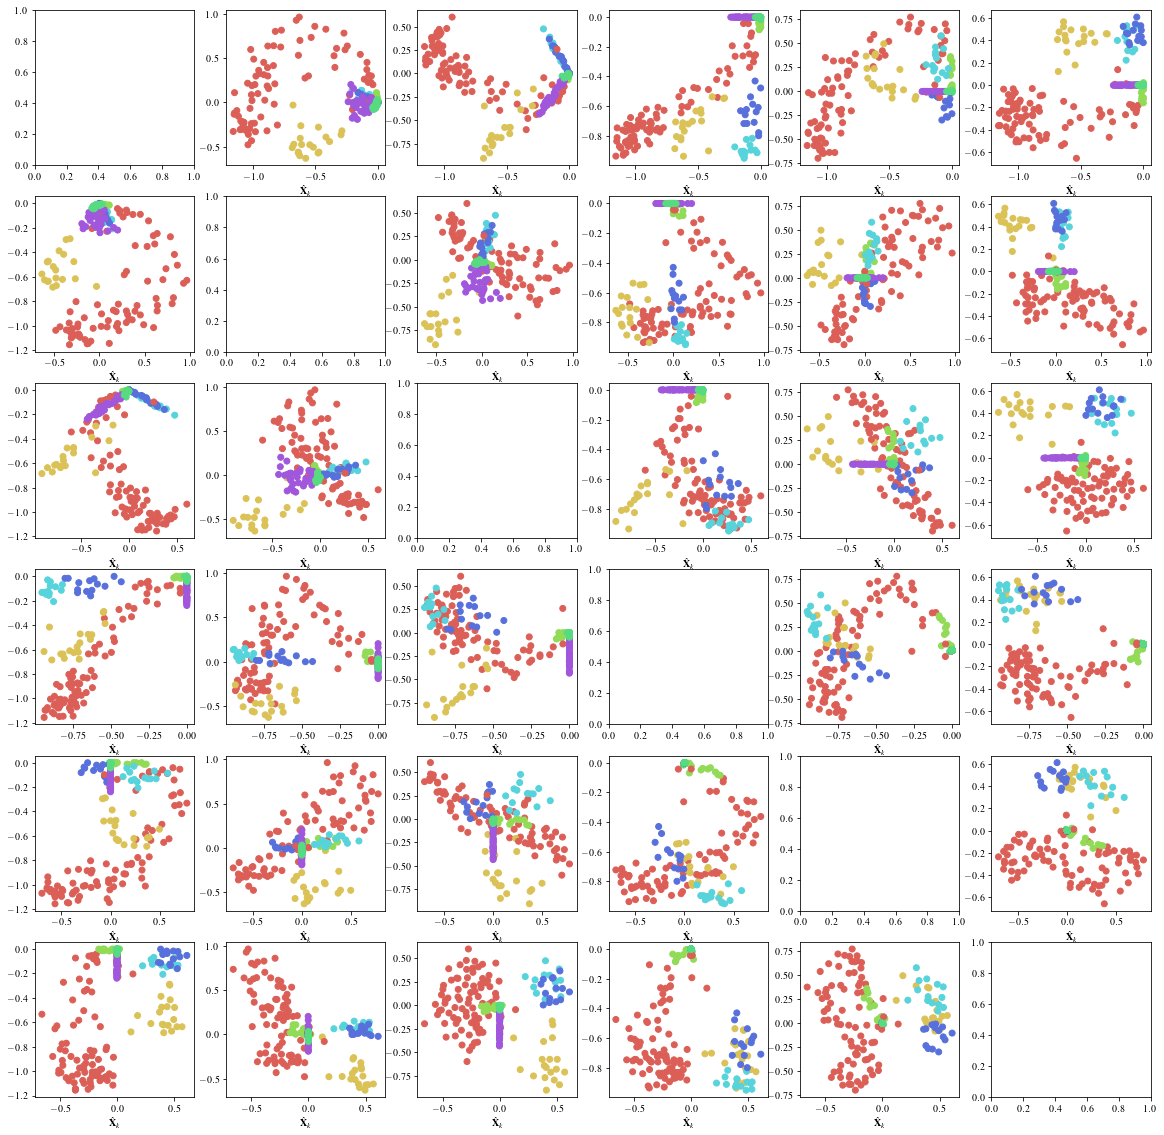

In [39]:
plt.rcParams['figure.figsize'] = [20, 20]
import seaborn as sns
zcol = [sns.color_palette("hls", 8)[z] for z in z_est]
fig, axs = plt.subplots(m.d,m.d)
for k in range(m.d):
    for h in range(m.d):
        if k != h:
            axs[k,h].scatter(m.X[:,k],m.X[:,h],c=zcol)
plt.show()

Calculate ARI for estimated clustering:

In [ ]:
ari(z_est, lab)

Histogram of K:

In [ ]:
from collections import Counter
plt.rcParams['figure.figsize'] = [6, 4]
Kc = Counter(np.apply_along_axis(func1d=lambda x: len(np.unique(x)), axis=0, arr=q[1][:,0]))
Kx = np.array(list(Kc.keys()))
Ky = np.array(list(Kc.values())) / np.sum(np.array(list(Kc.values())))
plt.bar(x=Kx, height=Ky, color='lightgray', edgecolor='black')
plt.axvline(x=4, ls='--', c='red')
plt.xlabel('$K$')
plt.ylabel('Frequency')
plt.show()